### PART II - Import Packages & Dataset

In [94]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

pd.set_option('display.max_rows', 250)
%matplotlib inline

df = pd.read_csv('C:/Users/anbento/Documents/kpis_with_flags_data.csv',parse_dates = ['observation_date'])

print('Dataset Shape:', df.shape)
print('Max Obs. Date:',df['observation_date'].min())
print('Max Obs. Date:',df['observation_date'].max())
df.head()

Dataset Shape: (1826, 7)
Max Obs. Date: 2017-01-01 00:00:00
Max Obs. Date: 2021-12-31 00:00:00


,observation_date,sales_num,sales_value_gbp,fl_last_working_day,fl_first_working_day,fl_last_friday,fl_new_year
0,2017-01-01,779.0,453330.60,0,0,0,1
1,2017-01-02,1158.0,869178.32,0,1,0,0
2,2017-01-03,1406.0,1169019.45,0,0,0,0
3,2017-01-04,1484.0,1216797.41,0,0,0,0
4,2017-01-05,1516.0,1265103.60,0,0,0,0


### Create Holidays DF

In [95]:
### 1. GENERATE LIST OF DATES EXTRACTED FROM FLAGS ###
fl_last_working_day = df.loc[df['fl_last_working_day'] == 1]['observation_date'].to_list()

fl_first_working_day = df.loc[df['fl_first_working_day'] == 1]['observation_date'].to_list()

fl_last_friday = df.loc[df['fl_last_friday'] == 1]['observation_date'].to_list()

fl_new_year = df.loc[df['fl_new_year'] == 1]['observation_date'].to_list()


### 2. CREATE A DATAFRAME FOR EACH RECURRING EVENT ###
First_Working_Day = pd.DataFrame({'holiday': 'First_Working_Day',
                                  'ds':  pd.to_datetime(fl_first_working_day),
                                  'lower_window': 0,
                                  'upper_window': 0 })

Last_Working_Day = pd.DataFrame({'holiday': 'Last_Working_Day',
                                 'ds':  pd.to_datetime(fl_last_working_day),
                                 'lower_window': 0,
                                 'upper_window': 0 })

Last_Friday = pd.DataFrame({'holiday': 'Last_Friday',
                            'ds':  pd.to_datetime(fl_last_friday),
                            'lower_window': 0,
                            'upper_window': 0 })

New_Year = pd.DataFrame({'holiday': 'New_Year',
                         'ds':  pd.to_datetime(fl_new_year),
                         'lower_window': 0,
                         'upper_window': 0 })

# manually imputed dates covering oberved + forecast period
Christmas = pd.DataFrame({'holiday': 'Christmas',
                         'ds': pd.to_datetime(['2017-12-25','2018-12-25', 
                                               '2019-12-25', '2020-12-25', 
                                               '2021-12-25']),
                         'lower_window': -3,
                         'upper_window': 3 })
# manually imputed dates covering oberved + forecast period
Easter = pd.DataFrame({'holiday': 'Easter',
                         'ds': pd.to_datetime(['2017-04-16', '2018-04-01', 
                                              '2019-04-21', '2020-04-12',
                                              '2021-04-04']),
                         'lower_window': -4,
                         'upper_window': 2 })

# 3. CONCATENATE SINGLE DATAFRAMES TO FORM HOLIDAYS DATAFRAME

holidays= pd.concat([First_Working_Day, Last_Working_Day, Last_Friday, 
                     New_Year, Christmas, Easter])

#holidays.head(5)
#holidays.tail(5)

cutoff_date = pd.to_datetime('2020-10-31') 
test_end_date = pd.to_datetime('2020-11-30')

forecast_start_date = pd.to_datetime('2020-11-01')
forecast_end_date = pd.to_datetime('2022-01-01')
days_to_forecast = pd.Timedelta(forecast_end_date - forecast_start_date).days



### Model Adding Holidays

In [58]:
kpis = ['sales_num']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear', 
                    seasonality_mode = 'multiplicative',
                    daily_seasonality = False,
                    weekly_seasonality=True,
                    yearly_seasonality=True,
                    holidays=holidays,
                    changepoint_prior_scale=0.1,
                    #changepoint_range=0.85,
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    
    forecast = model.predict(future_data)
#     df.loc[(df['observation_date'] > cutoff_date ), kpi ] = forecast['yhat'].astype(int)

# df.tail(10)

Forecasting KPI:  sales_num


### Compute MAPE For Model With Holidays

In [61]:
combined_df = df.join(forecast, how = 'outer')
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]

mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
mape

4.78664908141909

### Plot Actuals vs Predictions - Note Increase Accuracy

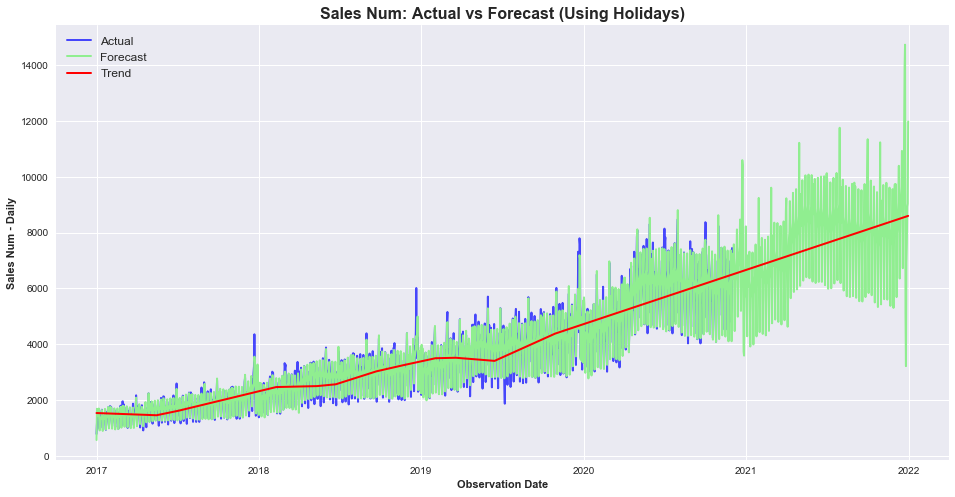

In [62]:
plt.figure(figsize=(16,8))
plt.plot(combined_df['observation_date'], combined_df['sales_num'], 
         linewidth=2, color = 'blue' ,alpha = 0.7, label = 'Actual')
plt.plot(combined_df['observation_date'], combined_df['yhat'], 
         linewidth=2, color = 'lightgreen', label = 'Forecast')
plt.plot(combined_df['observation_date'], combined_df['trend'], 
         linewidth=2, color = 'red', label = 'Trend')

plt.title('Sales Num: Actual vs Forecast (Using Holidays)', fontsize=16, fontweight='heavy' )
plt.xlabel('Observation Date', fontweight='heavy')
plt.ylabel('Sales Num - Daily', fontweight='heavy')
plt.legend(loc="upper left", fontsize = 'large')

### Model Adding Holidays, Customized Seasonalities and Advanced Parameters

In [195]:
kpis = ['sales_num']

for kpi in kpis:
    print('Forecasting KPI: ', kpi)
    df_train = df.loc[(df[kpi].notnull()) & (df['observation_date'] <= cutoff_date ), ['observation_date', kpi]]

    df_train = df_train.rename(columns={'observation_date': 'ds', kpi: 'y'})
    
    model = Prophet(interval_width=0.95,
                    growth = 'linear',
                    seasonality_mode = 'multiplicative',
                    #seasonality_prior_scale = 15, #alternatively set global parameter
                    daily_seasonality=False,
                    weekly_seasonality=False, 
                    yearly_seasonality=False,
                    holidays=holidays,
                    holidays_prior_scale = 10,
                    ).add_seasonality(
                   name = 'weekly',
                    period = 7,
                    fourier_order = 5,
                    prior_scale = 15
                    ).add_seasonality(
                    name = 'monthly',
                    period = 30.5,
                    fourier_order = 14,
                    prior_scale = 15
                    ).add_seasonality(
                    name = 'yearly',
                    period = 365.25,
                    fourier_order = 10,
                    prior_scale = 15
                    )
    model.fit(df_train)
    future_data = model.make_future_dataframe(periods= days_to_forecast )
    forecast = model.predict(future_data)

combined_df = df.join(forecast, how = 'outer')
combined_df_test = combined_df.loc[(combined_df['observation_date'] > cutoff_date)
                                    & (combined_df['observation_date'] <= test_end_date )]

mape =(np.mean(np.abs(combined_df_test['sales_num']-combined_df_test['yhat'])/
               np.abs(combined_df_test['sales_num'])))*100
mape


Forecasting KPI:  sales_num


3.5913599938863006